In [27]:
from pathlib import Path

# Define root project folder
ROOT = Path("/content/dr-project")
ROOT.mkdir(parents=True, exist_ok=True)


In [28]:
!rm -rf /content/dr-project
!mkdir -p /content/dr-project/{data/images,models,runs}
ROOT = "/content/dr-project"


In [29]:
!pip -q install medmnist pillow pandas matplotlib


In [30]:
import medmnist, numpy as np, pandas as pd, matplotlib.pyplot as plt
print("medmnist", medmnist.__version__)


medmnist 3.0.2


In [32]:
from medmnist.dataset import RetinaMNIST
from pathlib import Path
from PIL import Image
import numpy as np, pandas as pd

IMG_DIR = Path(ROOT)/"data/images"
IMG_DIR.mkdir(parents=True, exist_ok=True)

rows = []
def dump_split(ds, split):
    for i in range(len(ds)):
        img, target = ds[i]
        grade = int(target if not hasattr(target,"__len__") else target[0])
        _id = f"{split}_{i:05d}"
        Image.fromarray(np.array(img)).save(IMG_DIR/f"{_id}.png")
        # 0 = No DR, 1–4 = DR
        label = 0 if grade==0 else 1
        rows.append({"id":_id, "label":label, "split":split})

train_ds = RetinaMNIST(split="train", download=True, as_rgb=True)
val_ds   = RetinaMNIST(split="val",   download=True, as_rgb=True)
test_ds  = RetinaMNIST(split="test",  download=True, as_rgb=True)

dump_split(train_ds,"train")
dump_split(val_ds,"val")
dump_split(test_ds,"test")

df = pd.DataFrame(rows)[["id","label","split"]]
df.to_csv(Path(ROOT)/"data/labels.csv", index=False)
df.head()


,id,label,split
0,train_00000,0,train
1,train_00001,0,train
2,train_00002,0,train
3,train_00003,1,train
4,train_00004,1,train


In [33]:
from PIL import Image
import numpy as np, pandas as pd
from pathlib import Path

DATA = Path(ROOT)/"data"
labels = pd.read_csv(DATA/"labels.csv")

IMG_SIZE = 64

def load_vec(image_id):
    im = Image.open(DATA/"images"/f"{image_id}.png").convert("RGB").resize((IMG_SIZE,IMG_SIZE)).convert("L")
    arr = np.array(im, dtype=np.float32)/255.0
    return arr.reshape(-1)

def make_Xy(split):
    d = labels[labels.split==split].reset_index(drop=True)
    X = np.stack([load_vec(i) for i in d.id], axis=0)
    y = d.label.values.reshape(-1,1).astype(np.float32)
    return X,y,d

X_train,y_train,df_train = make_Xy("train")
X_val,  y_val,  df_val   = make_Xy("val")
X_test, y_test, df_test  = make_Xy("test")

X_train.shape, y_train.shape


((1080, 4096), (1080, 1))

In [40]:
# standardize features (z-score using train stats)
mu = X_train.mean(axis=0, keepdims=True)
sd = X_train.std(axis=0, keepdims=True) + 1e-8

Xtr = (X_train - mu)/sd
Xv  = (X_val   - mu)/sd
Xte = (X_test  - mu)/sd

# optional sanity check
float(Xtr.mean()), float(Xtr.std())


(1.257216467820399e-06, 1.000000238418579)

In [36]:
# metric helpers (all from scratch)
def cm_binary(y_true, y_pred):
    y_true = y_true.astype(int).flatten()
    y_pred = y_pred.astype(int).flatten()
    tn = ((y_true==0)&(y_pred==0)).sum()
    fp = ((y_true==0)&(y_pred==1)).sum()
    fn = ((y_true==1)&(y_pred==0)).sum()
    tp = ((y_true==1)&(y_pred==1)).sum()
    return np.array([[tn,fp],[fn,tp]])

def metrics(y_true, y_pred):
    cm = cm_binary(y_true, y_pred)
    tn,fp,fn,tp = cm[0,0],cm[0,1],cm[1,0],cm[1,1]
    acc  = (tn+tp)/cm.sum()
    prec = tp/(tp+fp+1e-12)
    rec  = tp/(tp+fn+1e-12)
    f1   = 2*prec*rec/(prec+rec+1e-12)
    return acc,prec,rec,f1,cm

def roc_from_probs(y_true, p, K=400):
    y_true = y_true.flatten()
    T = np.linspace(0,1,K)
    fpr,tpr = [],[]
    for t in T:
        y_pred = (p>=t).astype(int)
        cm = cm_binary(y_true, y_pred)
        tn,fp,fn,tp = cm[0,0],cm[0,1],cm[1,0],cm[1,1]
        tpr.append(tp/(tp+fn+1e-12))
        fpr.append(fp/(fp+tn+1e-12))
    order = np.argsort(fpr)
    fpr,tpr = np.array(fpr)[order], np.array(tpr)[order]
    auc = np.trapz(tpr, fpr)
    return fpr,tpr,auc


In [37]:
# logistic regression
def sigmoid(z): return 1/(1+np.exp(-np.clip(z, -50, 50)))

class LogisticRegressionScratch:
    def __init__(self, lr=0.5, epochs=60, batch=256, l2=1e-4, patience=8):
        self.lr, self.epochs, self.batch, self.l2, self.patience = lr,epochs,batch,l2,patience
        self.w = None

    def _add_bias(self, X): return np.hstack([np.ones((X.shape[0],1)), X])

    def fit(self, X, y, Xv=None, yv=None):
        Xb = self._add_bias(X); N,D = Xb.shape
        self.w = np.random.normal(0,0.01,(D,1))
        best_w, best_val, bad = self.w.copy(), 1e9, 0

        for ep in range(1,self.epochs+1):
            idx = np.random.permutation(N)
            for s in range(0,N,self.batch):
                Xmb = Xb[idx[s:s+self.batch]]; ymb = y[idx[s:s+self.batch]]
                p = sigmoid(Xmb @ self.w)
                grad = Xmb.T @ (p-ymb) / max(1,len(Xmb))
                grad[1:] += self.l2*self.w[1:]           # L2 (no penalty on bias)
                self.w -= self.lr*grad
            # early stopping on val BCE
            if Xv is not None:
                pv = sigmoid(self._add_bias(Xv) @ self.w)
                eps=1e-12; pv=np.clip(pv,eps,1-eps)
                val = -np.mean(yv*np.log(pv)+(1-yv)*np.log(1-pv))
                if val < best_val - 1e-6: best_val, best_w, bad = val, self.w.copy(), 0
                else: bad += 1
                if bad >= self.patience: self.w = best_w; break

    def predict_proba(self, X): return sigmoid(self._add_bias(X) @ self.w)
    def predict(self, X): return (self.predict_proba(X) >= 0.5).astype(int)

model_lr = LogisticRegressionScratch()
model_lr.fit(Xtr, y_train, Xv, y_val)

pt_lr  = model_lr.predict_proba(Xte)
yhatLR = (pt_lr>=0.5).astype(int)
acc,prec,rec,f1,cm = metrics(y_test, yhatLR)
fpr_lr, tpr_lr, auc_lr = roc_from_probs(y_test, pt_lr)

print("LOGREG TEST  acc:", round(acc,3),
      "prec:", round(prec,3),
      "rec:",  round(rec,3),
      "f1:",   round(f1,3),
      "auc:",  round(auc_lr,3))
print("Confusion matrix:\n", cm)


LOGREG TEST  acc: 0.718 prec: 0.776 rec: 0.704 f1: 0.738 auc: 0.706
Confusion matrix:
 [[128  46]
 [ 67 159]]


/tmp/ipython-input-2043986576.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)


In [38]:
# k-nearest neighbors
def l2_distances(A,B):
    A2 = np.sum(A*A, axis=1, keepdims=True)
    B2 = np.sum(B*B, axis=1, keepdims=True).T
    D2 = A2 + B2 - 2*(A @ B.T)
    return np.sqrt(np.maximum(D2, 0.0))

def knn_predict_proba(Xq, Xtr, ytr, k=7):
    D = l2_distances(Xq, Xtr)
    idx = np.argpartition(D, k-1, axis=1)[:, :k]
    probs = ytr[idx].astype(int).mean(axis=1)
    return probs.reshape(-1,1)

# choose k on validation by F1
best = {"k":None, "f1":-1}
for k in range(3,12,2):     # 3,5,7,9,11
    pv = knn_predict_proba(Xv, Xtr, y_train, k)
    yvhat = (pv>=0.5).astype(int)
    _,_,_,f1,_ = metrics(y_val, yvhat)
    if f1 > best["f1"]: best = {"k":k, "f1":f1}
best_k = best["k"]; print("Best k:", best_k)

pt_knn  = knn_predict_proba(Xte, Xtr, y_train, k=best_k)
yhatKNN = (pt_knn>=0.5).astype(int)
acc_k,prec_k,rec_k,f1_k,cm_k = metrics(y_test, yhatKNN)
fpr_knn, tpr_knn, auc_knn = roc_from_probs(y_test, pt_knn)

print("KNN TEST (k=%d)  acc:"%best_k, round(acc_k,3),
      "prec:", round(prec_k,3),
      "rec:",  round(rec_k,3),
      "f1:",   round(f1_k,3),
      "auc:",  round(auc_knn,3))
print("Confusion matrix:\n", cm_k)


Best k: 11
KNN TEST (k=11)  acc: 0.71 prec: 0.789 rec: 0.664 f1: 0.721 auc: 0.757
Confusion matrix:
 [[134  40]
 [ 76 150]]


/tmp/ipython-input-2043986576.py:32: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)


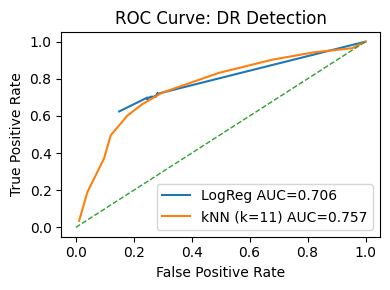

In [39]:
# plot + save ROC curve
plt.figure(figsize=(4,3))
plt.plot(fpr_lr,  tpr_lr,  label=f"LogReg AUC={auc_lr:.3f}")
plt.plot(fpr_knn, tpr_knn, label=f"kNN (k={best_k}) AUC={auc_knn:.3f}")
plt.plot([0,1],[0,1],"--",linewidth=1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve: DR Detection")
plt.legend(); plt.tight_layout()
plt.savefig("roc_curve.png", dpi=300, bbox_inches="tight")
plt.show()


In [ ]:
np.save(Path(ROOT)/"models/knn_Xtr.npy", Xtr)
np.save(Path(ROOT)/"models/knn_ytr.npy", y_train)
with open(Path(ROOT)/"models/knn_k.txt","w") as f: f.write(str(best_k))
